### Author: Allan Jeeboo 
### Preferred Name: Vyncent S. A. van der Wolvenhuizen 
### Affiliation: Student at TripleTen 
### Email: vanderwolvenhuizen.vyncent@proton.me
### Date Started: 2025-03-12 
### Last Updated: 2025-03-18 15:04

# 1.0 Introduction
This project places us in the role of developing a model that analyzes subscribers' behavior for the telecommunications company Megaline. This model will recommend one of their newer plans: Smart or Ultra. 

We have access to behavior data about subscribers who have already switched to the new plans (from the project for the Statistical Data Analysis sprint). For this classification task, we need to develop a model that will pick the right plan. Since we’ve already performed the data preprocessing step, we can move straight to creating the model. For good measure though, let's perform some quick preprocessing and a bit of EDA.

We'll create a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. We'll check the accuracy using the test dataset.

### 1.1 Module & Data Import

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('users_behavior.csv')

display(df.head()) 
print(f'rows, columns: {df.shape}')

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


rows, columns: (3214, 5)


### 1.2 Data Description
This dataset contains monthly behavior information regarding users.
- сalls: Number of calls.
- minutes: Total call duration in minutes.
- messages: Number of text messages.
- mb_used: Internet traffic used in MB.
- is_ultra: Plan for the current month (Ultra - 1, Smart - 0).

# 2.0 Preprocessing & EDA

### 2.1 Preprocessing

In [2]:
nans = df.isna().sum()
duplicates = df.duplicated().sum()
dtypes = df.dtypes 

print( f'nans: \n{nans}\n')
print(f'duplicates: {duplicates}\n') 
print(f'dtypes: \n{dtypes}\n')

nans: 
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

duplicates: 0

dtypes: 
calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object



Why are 'calls' and 'messages' floats? You can't have a fraction of a call or message, so let's fix those by converting them to ints.

In [3]:
df.calls = df.calls.astype('int')
df.messages = df.messages.astype('int')
print(f'dtypes: \n{df.dtypes}\n')

dtypes: 
calls         int64
minutes     float64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object



We've checked for NaNs, duplicates, and ensured the dtypes are as they should be. Let's proceed to EDA.

### 2.2 EDA
We'll begin by first filtering the dataframe on the "is_ultra" column into whether or not customers have Ultra. If they have Ultra, they'll be sorted into the "yes_ultra" dataframe; if not, then they'll be sorted into the "no_ultra" dataframe. The reason we're doing this is so that we can compare the two plans. After splitting the dataframe, we'll create two variables that count how many customers have ultra, represented by "has_ultra", and those who don't, represented by "not_has_ultra". Then we'll print the count and percentages of both variables. Afterwards, we'll create a barplot to visualize this information.

In [4]:
yes_ultra = df[df['is_ultra'] == 1]
no_ultra = df[df['is_ultra'] == 0]
has_ultra = yes_ultra['is_ultra'].count()
not_has_ultra = no_ultra['is_ultra'].count()

print(f'Customers with Ultra: {has_ultra}\nPercentage: {has_ultra/df.shape[0]*100:.2f}%')
print(f'Customers without Ultra: {not_has_ultra}\nPercentage: {not_has_ultra/df.shape[0]*100:.2f}%')

Customers with Ultra: 985
Percentage: 30.65%
Customers without Ultra: 2229
Percentage: 69.35%


([<matplotlib.axis.XTick at 0x286e55eef60>,
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

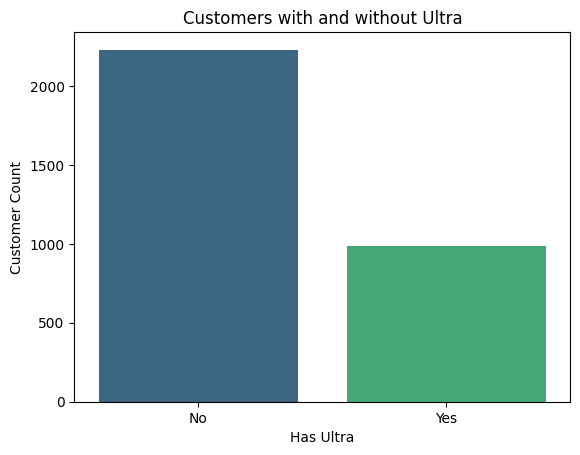

In [5]:
sns.barplot(x=['not_has_ultra', 'has_ultra'], 
            y=df['is_ultra'].value_counts(), 
            palette='viridis', 
            hue= ['not_has_ultra', 'has_ultra'])

plt.title('Customers with and without Ultra')
plt.xlabel('Has Ultra')
plt.ylabel('Customer Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

From the data we have, most customers don't have ultra - 2,229 or 69.35% to be precise. Now let's use the describe() method on both for a more thorough breakdown and create histograms to visualize the differences between various columns.

In [6]:
print('Description of customers with Ultra:')
display(yes_ultra.describe())
print('Description of customers without Ultra:')
display(no_ultra.describe())


Description of customers with Ultra:


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


Description of customers without Ultra:


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


### 2.3 Distribution of Calls

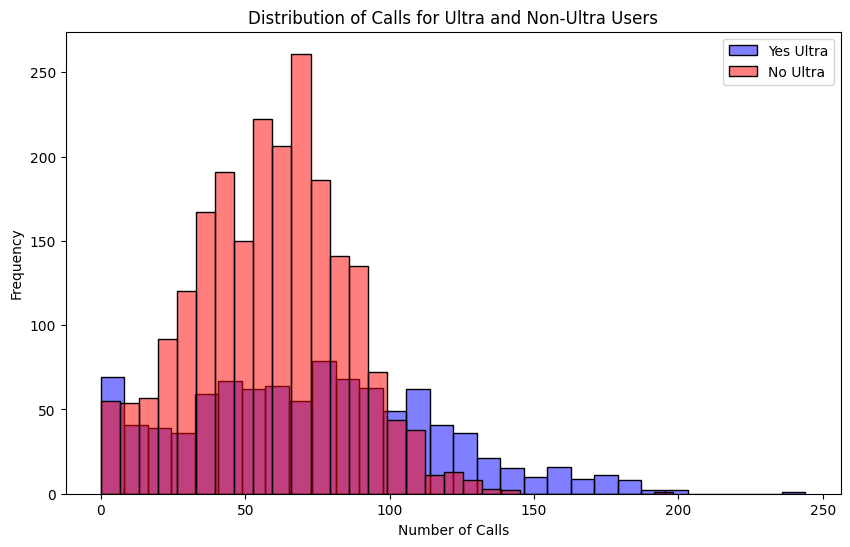

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(yes_ultra['calls'], 
             kde=False, bins=30, 
             color='blue', 
             label='Yes Ultra', 
             alpha=0.5)
sns.histplot(no_ultra['calls'], 
             kde=False, 
             bins=30, 
             color='red', 
             label='No Ultra', 
             alpha=0.5)
plt.title('Distribution of Calls for Ultra and Non-Ultra Users')
plt.xlabel('Number of Calls')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 2.4 Distribution of Minutes

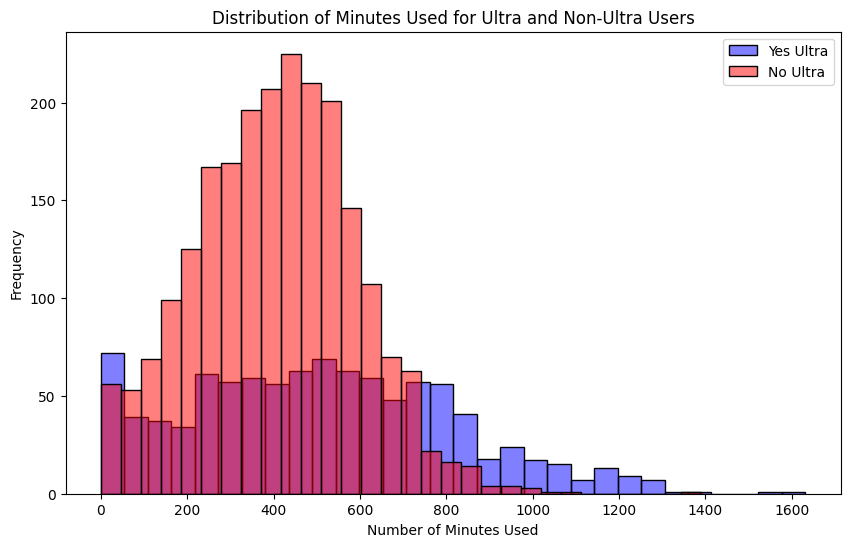

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(yes_ultra['minutes'], 
             kde=False, bins=30, 
             color='blue', 
             label='Yes Ultra', 
             alpha=0.5)
sns.histplot(no_ultra['minutes'], 
             kde=False, 
             bins=30, 
             color='red', 
             label='No Ultra', 
             alpha=0.5)
plt.title('Distribution of Minutes Used for Ultra and Non-Ultra Users')
plt.xlabel('Number of Minutes Used')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 2.5 Distribution of Messages

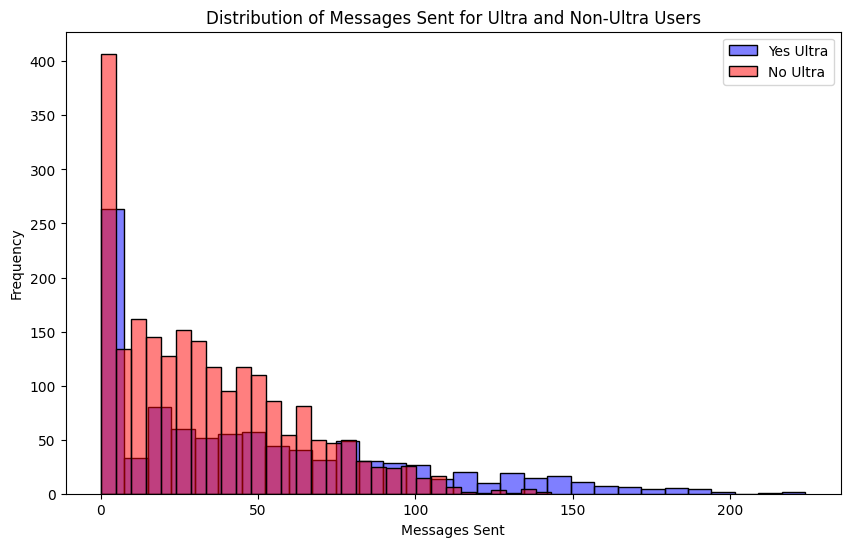

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(yes_ultra['messages'], 
             kde=False, bins=30, 
             color='blue', 
             label='Yes Ultra', 
             alpha=0.5)
sns.histplot(no_ultra['messages'], 
             kde=False, 
             bins=30, 
             color='red', 
             label='No Ultra', 
             alpha=0.5)
plt.title('Distribution of Messages Sent for Ultra and Non-Ultra Users')
plt.xlabel('Messages Sent')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 2.6 Distribution of MB Used

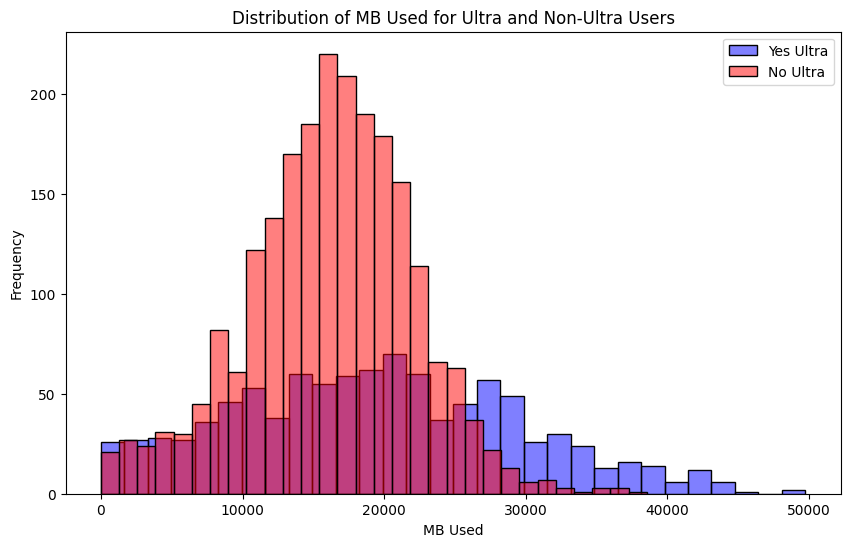

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(yes_ultra['mb_used'], 
             kde=False, bins=30, 
             color='blue', 
             label='Yes Ultra', 
             alpha=0.5)
sns.histplot(no_ultra['mb_used'], 
             kde=False, 
             bins=30, 
             color='red', 
             label='No Ultra', 
             alpha=0.5)
plt.title('Distribution of MB Used for Ultra and Non-Ultra Users')
plt.xlabel('MB Used')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3.0 Model Creation

In this section we'll be testing three types of models:  
- Decision Tree Classifier 
- Random Forest Classifier 
- Logistic Regression

We need to establish what our features and target are. Because we want to see who is already an ultra member, is_ultra will be our target. "is_ultra" is not numerical (it has binary representation, but it's classifying users into two groups.), so we'll use classification models. Everything except for "is_ultra" will be our features.

### 3.1 Decision Tree Classifier

First we need to establish the features and targets. Afterwards, we'll split the data set to obtain a test set; from the remainder of the initial set, we'll split that once more to obtain a validation set. I've chosen a test size and validation size of 0.2, so our data split has a ratio of 3:1:1. Throughout this project, we'll pass the arbitrary argument of 12345 to our random_state parameter.

In [11]:
features = df.drop('is_ultra', axis= 1) 
target = df['is_ultra']
train_valid, test = train_test_split(df, test_size= 0.2, random_state= 12345)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size= 0.2, random_state= 12345)

print(f'feature rows, columns:', features.shape)
print(f'target rows:', target.shape)
print(f'test rows, columns:', test.shape)

feature rows, columns: (3214, 4)
target rows: (3214,)
test rows, columns: (643, 5)


Now let's tune the model and see which depth yields the best accuracy.

In [12]:
best_dtc_accuracy = 0 
best_dtc_depth = 0 
best_dtc_model = None

for depth in range (1, 10): 
    decision_tree_model = DecisionTreeClassifier(random_state= 12345, max_depth= depth) 
    decision_tree_model.fit(features_train, target_train)
    predictions_valid = decision_tree_model.predict(features_valid) 
    print(f'Validation accuracy for depth {depth}: {accuracy_score(target_valid, predictions_valid)}')
    if accuracy_score(target_valid, predictions_valid) > best_dtc_accuracy: 
        best_dtc_accuracy = accuracy_score(target_valid, predictions_valid)
        best_dtc_depth = depth
        best_dtc_model = decision_tree_model

test_features = test.drop('is_ultra', axis = 1)
test_target = test['is_ultra']
train_pedictions = decision_tree_model.predict(features_train)
test_predictions = decision_tree_model.predict(test_features)

print(f'Accuracy on the train set: {accuracy_score(target_train, train_pedictions)}')
print(f'Best Decision Tree Classifier accuracy: {best_dtc_accuracy} with depth {best_dtc_depth}')
print(f'Accuracy on the test set: {accuracy_score(test_target, test_predictions)}')

Validation accuracy for depth 1: 0.7480559875583204
Validation accuracy for depth 2: 0.7807153965785381
Validation accuracy for depth 3: 0.7838258164852255
Validation accuracy for depth 4: 0.7791601866251944
Validation accuracy for depth 5: 0.7853810264385692
Validation accuracy for depth 6: 0.7822706065318819
Validation accuracy for depth 7: 0.7791601866251944
Validation accuracy for depth 8: 0.7729393468118196
Validation accuracy for depth 9: 0.7791601866251944
Accuracy on the train set: 0.8638661999222093
Best Decision Tree Classifier accuracy: 0.7853810264385692 with depth 5
Accuracy on the test set: 0.7791601866251944


Our sets have an accuracy, rounded to three decimal places, of:  
- Training: 86.888%
- Validation: 78.538%
- Test: 78.849%

Usually the test and validation sets have about the same value, and seeing as the difference here is a mere 0.311%, that's a good sign.
In addition to that, a max depth of 5 appears to yield the best validation accuracy.

### 3.2 Random Forest Classifier

Random Forest Classifiers have the highest degree of accuracy due to the fact that it generates a specified quantity of independent trees, then votes on the best model. The downside though is that due to the fact that it's generating multiple trees, it has a low speed.

In [13]:
best_score = 0 
best_est = 0 
for est in range(1, 100): 
    random_forest_model = RandomForestClassifier(random_state= 12345, n_estimators= est) 
    random_forest_model.fit(features_train, target_train)
    score_valid = random_forest_model.score(features_valid, target_valid)
    if score_valid > best_score: 
        best_score = score_valid
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

final_model = RandomForestClassifier(random_state=12345, n_estimators=best_est) # change n_estimators to get best model
final_model.fit(features_train, target_train)
train_predictions = final_model.predict(features_train)
test_predictions = final_model.predict(test_features)
print(f'Accuracy on the train set: {accuracy_score(target_train, train_predictions)}')
print(f'Accuracy on the test set: {accuracy_score(test_target, test_predictions)}')

Accuracy of the best model on the validation set (n_estimators = 20): 0.7884914463452566
Accuracy on the train set: 0.9906651108518086
Accuracy on the test set: 0.7884914463452566


Our sets have an accuracy, rounded to three decimal places, of:  
- Training: 99.067%
- Validation: 78.849%
- Test: 79.849%

In addition to that, the best estimate in range 1 to 100 appears to be n_estimators= 20. 

The validation set for the Random Forest typically tends to yields a higher accuracy than that of the Decision Tree, and it just barely does so in this test.

### 3.3 Logistic Regression

In [14]:
logistic_model = LogisticRegression(random_state= 12345, solver= 'liblinear')
logistic_model.fit(features_train, target_train)  # train model on training set
score_train = logistic_model.score(features_train, target_train) # calculate accuracy score on training set  
score_valid = logistic_model.score(features_valid, target_valid)
     # calculate accuracy score on validation set  

print(
    "Accuracy of the logistic regression model on the training set:",
    score_train,
)
print(
    "Accuracy of the logistic regression model on the validation set:",
    score_valid,
)

Accuracy of the logistic regression model on the training set: 0.7016725009723843
Accuracy of the logistic regression model on the validation set: 0.702954898911353


Our sets have an accuracy, rounded to three decimal places, of:  
- Training: 70.167%
- Validation: 70.295%

The logistic regression model has the lowest accuracy of all tested model types.

# 4.0 Conclusion

Through this project, we have tested three models and they've yielded the following validation accuracies:
 - Decision Tree Classifier: 78.538%. A max depth of 7 yielded the best results.
 - Random Forest Classifier: 78.849%. n_estimators= 20 yielded the best results. 
 - Logistic Regression: 70.295% 

Validation accuracy reflects how often the model reaches the correct answer. Seeing as there are two possible answers to whether or not Megaline users are ultra users or not, our sanity check threshold is 50%; i.e., through random chance the result would be right half of the time. All of our models produced results above that, but for the 75% threshold mentioned at the beginning of this project, the Logistic Regression model failed to exceed that. That being said, the Random Forest Classifier appears to be the best model to use in regards to recommending plans to Megaline customers. One downside that needs to be reiterated is that because this type of model is processing multiple trees, it is the slowest. 